In [1]:
#pip install tensorflow

In [2]:
#pip install matplotlib

In [3]:
#pip install climetlab

In [4]:
#pip install climetlab-eumetnet-postprocessing-benchmark

In [5]:
#pip install --upgrade jupyterlab ipywidgets

In [6]:
#pip install requests

In [7]:
#pip install tensorrt

In [8]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint


2024-04-25 12:50:43.489269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 12:50:44.750553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
# Fetching the data from API
# Vienna, timeseries, 1h-1km, all parameters, 2018-2023 (01-01)

url = "https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2018-01-01T00%3A00&end=2024-01-01T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2018_2023_0101"
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print("Fetched data successfully")
else:
    print("Failed to retrieve data", response.status_code)

# Processing the data
data_list = []
for feature in data['features']:
    location = feature['geometry']['coordinates']
    for i, timestamp in enumerate(data['timestamps']):
        record = {
            'time': pd.to_datetime(timestamp),
            'longitude': location[0],
            'latitude': location[1],
            'RR': feature['properties']['parameters']['RR']['data'][i],
            'T2M': feature['properties']['parameters']['T2M']['data'][i],
            'RH2M': feature['properties']['parameters']['RH2M']['data'][i],
            'TD2M': feature['properties']['parameters']['TD2M']['data'][i],
            'GL': feature['properties']['parameters']['GL']['data'][i],
            'UU': feature['properties']['parameters']['UU']['data'][i],
            'VV': feature['properties']['parameters']['VV']['data'][i],
            'P0': feature['properties']['parameters']['P0']['data'][i]
        }
        data_list.append(record)

original_df = pd.DataFrame(data_list)

Fetched data successfully


In [18]:
df = original_df.copy()

In [11]:
df.dropna(inplace=True)  # Drop rows with NaN values first

# Feature engineering and selection
df['hour'] = df['time'].dt.hour
df['week_of_year'] = df['time'].dt.isocalendar().week
df['month'] = df['time'].dt.month

df['wind_speed'] = np.sqrt(df['UU']**2 + df['VV']**2)
df['wind_direction'] = np.arctan2(df['VV'], df['UU']) * 180 / np.pi

df['temp_humidity_interaction'] = df['T2M'] * df['RH2M']
df['wind_rain_interaction'] = df['wind_speed'] * df['RR']

df['RR_lag1'] = df['RR'].shift(1)
df['T2M_lag1'] = df['T2M'].shift(1)

df.dropna(inplace=True)
#plotting_df = df.drop(columns=df[['time']])
df = df.select_dtypes(include=[np.number])

# If you dropped rows from df, you need to ensure that 'time' aligns correctly:
#df['time'] = df['time'].iloc[df.index]  # Adjusts 'time' to align with the modified index after dropping rows

df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,hour,week_of_year,month,wind_speed,wind_direction,temp_humidity_interaction,wind_rain_interaction,RR_lag1,T2M_lag1
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,1,1,1,2.237878,159.054397,112.5891,0.00000,0.0,1.68
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,2,1,1,0.396232,47.045408,39.7680,0.00000,0.0,1.17
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,3,1,1,0.645136,18.996654,51.0000,0.00000,0.0,0.40
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,4,1,1,0.873212,29.500725,49.0000,0.00000,0.0,0.51
5,16.638773,48.334339,0.000,0.60,100.00,0.60,0.0,0.43,-0.55,100951.46,5,1,1,0.698140,-51.981057,60.0000,0.00000,0.0,0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,20,52,12,0.268701,45.000000,194.7894,0.00000,0.0,1.52
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,21,52,12,1.185960,24.403972,208.1041,0.00000,0.0,2.26
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,22,52,12,0.262488,40.364537,155.2408,0.00000,0.0,2.51
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,23,52,12,4.358497,22.387285,350.9397,0.00000,0.0,1.84


In [12]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

# Train test split
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Sequence creation for LSTM
def create_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data.iloc[i:(i + sequence_length)].values)
        y.append(input_data.iloc[i + sequence_length]['RR'])
    return np.array(X), np.array(y)

sequence_length = 24
X_train, y_train = create_sequences(train_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)

# Reshape data for ConvLSTM
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1, 1, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, X_test.shape[2]))

# Model creation
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', input_shape=(sequence_length, 1, 1, X_train.shape[-1]), return_sequences=True),
    ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=False),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

2024-04-25 13:40:52.694101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 13:40:53.060859: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 24, 1, 1, 64)   │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 1, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,621 (139.14 KB)

 Trainable params: 35,621 (139.14 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define the checkpoint path and filename
checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Set to False if you want to save the entire model
    monitor='val_loss',  # Metric to monitor
    mode='min',  # The lower the val_loss, the better
    save_best_only=True,  # Only save a model if `val_loss` has improved
    verbose=1  # Log message when saving the model
)

In [15]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5, 
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

Epoch 1/5


2024-04-25 13:41:11.370526: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153330912 exceeds 10% of free system memory.


2626/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5469e-04

2024-04-25 13:42:18.917802: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38300352 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.00012, saving model to checkpoints/model_epoch_01_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 71s 25ms/step - loss: 1.5467e-04 - val_loss: 1.1987e-04
Epoch 2/5
2625/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1490e-04
Epoch 2: val_loss improved from 0.00012 to 0.00012, saving model to checkpoints/model_epoch_02_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - loss: 1.1489e-04 - val_loss: 1.1670e-04
Epoch 3/5
2625/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1221e-04
Epoch 3: val_loss improved from 0.00012 to 0.00011, saving model to checkpoints/model_epoch_03_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - loss: 1.1220e-04 - val_loss: 1.0525e-04
Epoch 4/5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.1103e-05
Epoch 4: val_loss improved from 0.00011 to 0.00010, saving model to checkpoints/model_epoch_04_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/ste

In [16]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

2024-04-25 13:53:35.512991: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38300352 exceeds 10% of free system memory.


657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Mean Squared Error: 0.00010332287153321712
Root Mean Squared Error: 0.010164785857715701
Mean Absolute Error: 0.0023311621712987806


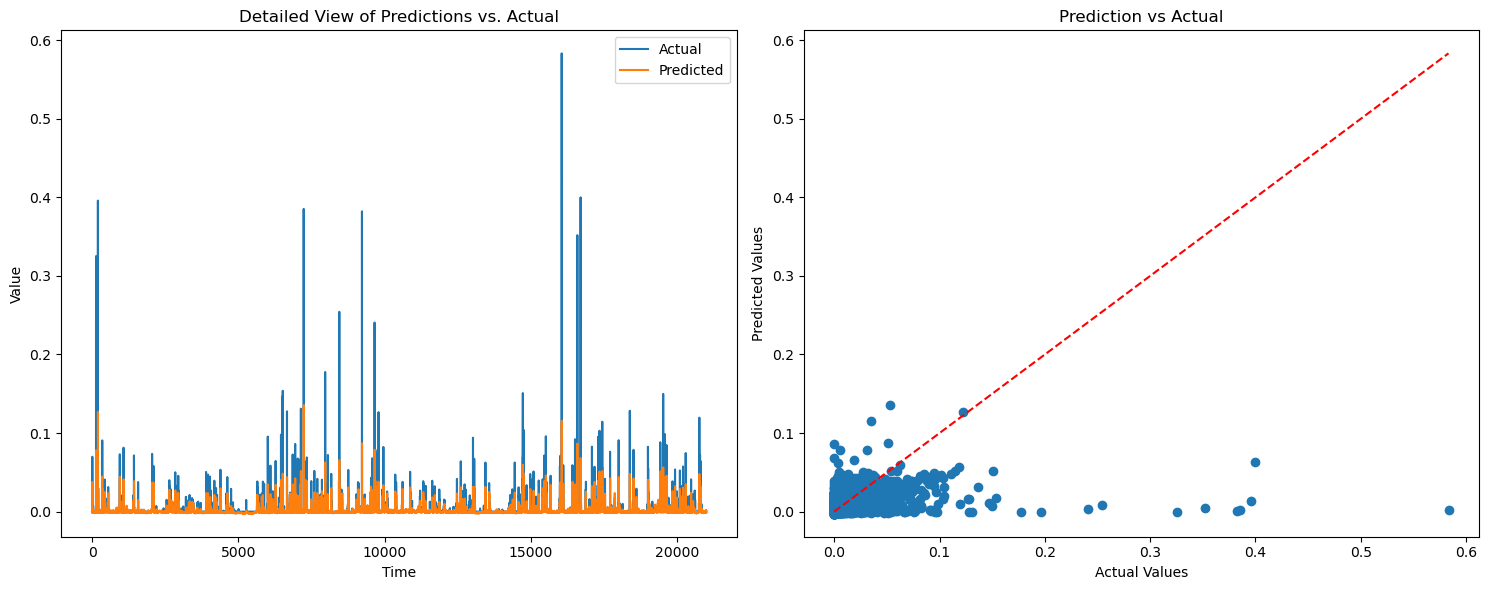

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal predictions line

plt.tight_layout()
plt.show()


In [17]:
# Continue with your scaling and data preparation
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['time']))  # Exclude 'time' or any non-numeric columns before scaling
df = pd.DataFrame(df_scaled, columns=[col for col in df.columns if col != 'time'])  # Re-create DataFrame without 'time'

# Re-attach the 'time' column if necessary for splits or future plotting
df['time'] = plotting_df['time']

# Create training and testing sets
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

train_df_time = train_df.drop(columns=['time'])
test_df_time = test_df.drop(columns=['time'])

In [9]:
def create_sequences(input_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data.iloc[i:(i + sequence_length)].values)
        y.append(input_data.iloc[i + sequence_length]['RR'])
    return np.array(X), np.array(y)

sequence_length = 24
X_train, y_train = create_sequences(train_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)

# Reshape data for ConvLSTM
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1, 1, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, X_test.shape[2]))


In [10]:
# Model creation
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', input_shape=(sequence_length, 1, 1, X_train.shape[-1]), return_sequences=True),
    ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=False),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

2024-04-23 14:12:49.643427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 14:12:49.645987: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 24, 1, 1, 64)   │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 1, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,877 (140.14 KB)

 Trainable params: 35,877 (140.14 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define the checkpoint path and filename
checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Set to False if you want to save the entire model
    monitor='val_loss',  # Metric to monitor
    mode='min',  # The lower the val_loss, the better
    save_best_only=True,  # Only save a model if `val_loss` has improved
    verbose=1  # Log message when saving the model
)

In [13]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5, 
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [13]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Mean Squared Error: 0.00010144797809832371
Root Mean Squared Error: 0.010072138705276238
Mean Absolute Error: 0.0019713988376412533


In [15]:
# Ensure that the indices match for test_time and test_df
test_df['time'] = test_time.reset_index(drop=True)

# Now let's handle adding predictions safely
# It's crucial to reset indices if there were any row filtering or dropping
test_df = test_df.reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred, columns=['predictions'])

# If y_pred_df has a different length, let's find out why
print("Length of test_df:", len(test_df))
print("Length of y_pred:", len(y_pred_df))

# Assuming they are now the same, or you've handled discrepancies
test_df['predictions'] = y_pred_df['predictions']


Length of test_df: 21022
Length of y_pred: 20998


/tmp/ipykernel_78697/3869611161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['time'] = test_time.reset_index(drop=True)


In [16]:

test_df['time'] = test_time
test_df['predictions'] = y_pred  # Assuming y_pred are your model's predictions

# Sort by time if necessary (it depends on whether the order was preserved)
test_df.sort_values('time', inplace=True)

# Plotting actual vs predicted values with time on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(test_df['time'], test_df['actual'], label='Actual Values')  # Ensure there's an 'actual' column or adjust accordingly
plt.plot(test_df['time'], test_df['predictions'], label='Predicted Values')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

ValueError: Length of values (20998) does not match length of index (21022)

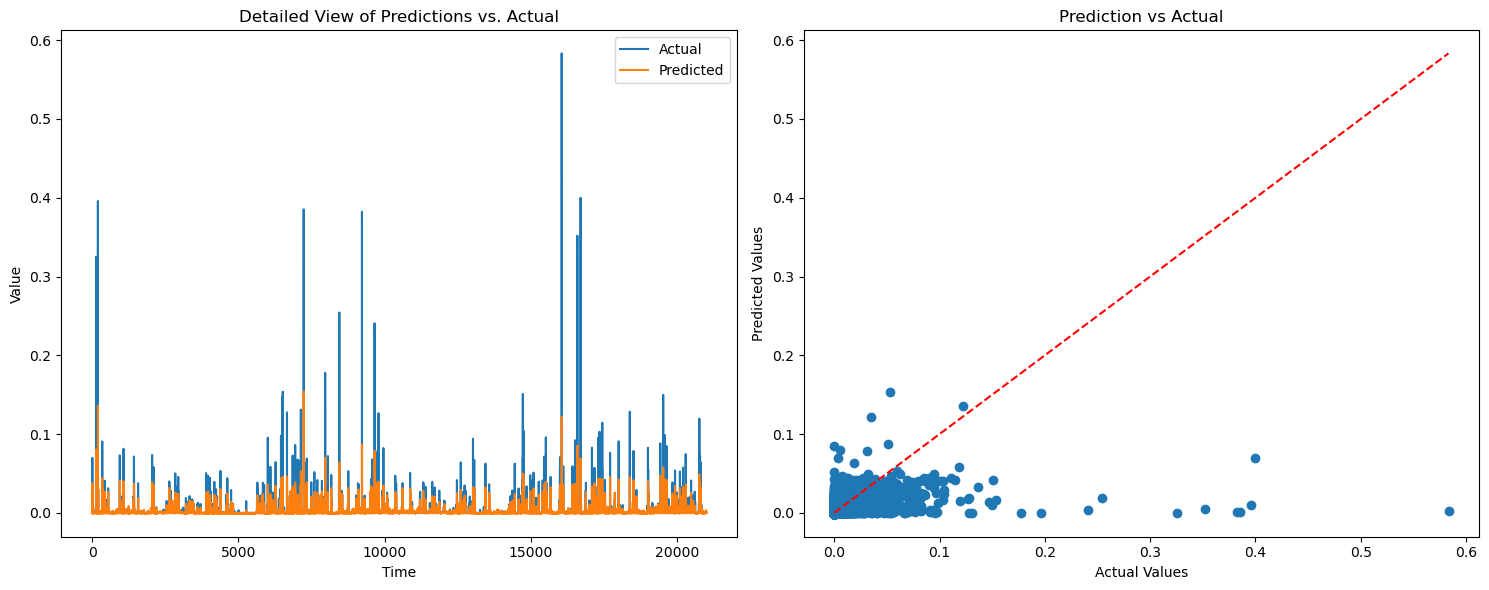

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal predictions line

plt.tight_layout()
plt.show()


In [ ]:
# Example of merging predictions back with the original time for plotting
results_df = test_df[['time']].copy()  # Starting with time from the test set
results_df['actual'] = y_test  # Assuming y_test is accessible and aligned
results_df['predicted'] = y_pred  # Assuming y_pred is obtained from the model

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(results_df['time'], results_df['actual'], label='Actual', linewidth=2)
plt.plot(results_df['time'], results_df['predicted'], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted over Time')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()


In [85]:
# Save the entire model to a HDF5 file
model_name = "final_model{date:%Y%m%dT%H%M%S}.h5".format(date=datetime.now())
model.save(model_name)

# Load the model back
from tensorflow.keras.models import load_model
loaded_model = load_model(model_name)

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [53]:
# Define the sequence length and the shape of your input data
sequence_length = 24  # Example sequence length
feature_dim = X_train.shape[-1]  # Extract feature dimension from your training data

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu',
               input_shape=(sequence_length, 1, 1, X_train.shape[-1]), return_sequences=True),
    Dropout(0.3),
    ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=False),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


# Print the model summary to check the architecture and parameter count
model.summary()


/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 24, 1, 1, 64)   │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 1, 1, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 1, 1, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,857 (151.79 KB)

 Trainable params: 38,857 (151.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 24, 1, 1, 64)   │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 1, 1, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 1, 1, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,857 (151.79 KB)

 Trainable params: 38,857 (151.79 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
def custom_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Then use 'custom_mse' as your loss function when compiling the model
model.compile(optimizer='adam', loss=custom_mse)

# Save and load the model
model.save('my_custom_model.keras')
loaded_model = load_model('my_custom_model.keras', custom_objects={'custom_mse': custom_mse})


/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


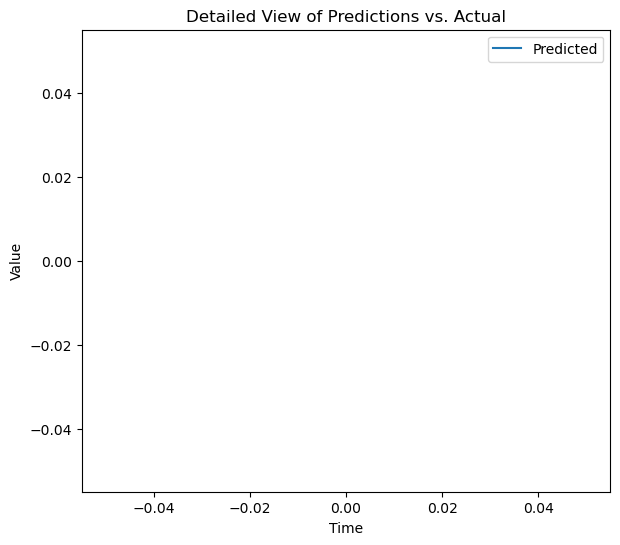

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_pred, label='Predicted')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()


In [27]:
print(y_pred[:10])  # Print the first 10 prediction values to see if they are all the same or very close to each other.


[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Assuming `model` has the same architecture as the one used during the checkpointing
checkpoint_path = "model_name"  # Update this to your actual checkpoint file

# Load the best saved weights
model.load_weights(checkpoint_path)

# Optionally, adjust the learning rate for fine-tuning
optimizer = Adam(learning_rate=0.0001)  # Lower rate than initial training
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Define new callbacks for the fine-tuning phase if needed
fine_tune_checkpoint = ModelCheckpoint(
    "checkpoints/fine_tuned_model_epoch_{epoch:02d}.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Continue training with new data
additional_epochs = 10
history_fine_tuning = model.fit(
    new_data,  # Your new dataset
    new_labels,
    epochs=additional_epochs,
    validation_split=0.2,
    callbacks=[fine_tune_checkpoint]  # Include fine-tuning specific callbacks
)

# Optionally save the fine-tuned model
model.save('fine_tuned'+ model_name + '.h5')

In [43]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

2024-04-22 22:49:32.194742: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50395200 exceeds 10% of free system memory.


657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Mean Squared Error: 0.00012750347527623986
Root Mean Squared Error: 0.011291743677406065
Mean Absolute Error: 0.0024631347603308188


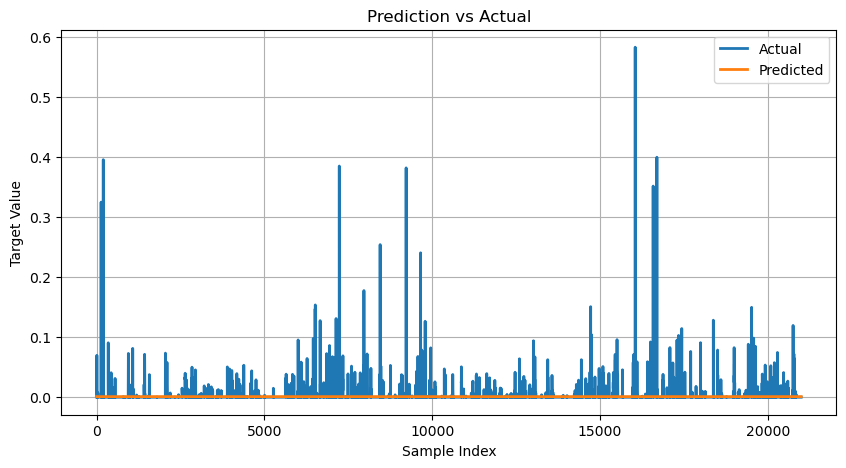

In [47]:
import matplotlib.pyplot as plt

# Assuming `y_test` and `y_pred` are both numpy arrays and have the same shape
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title('Prediction vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()


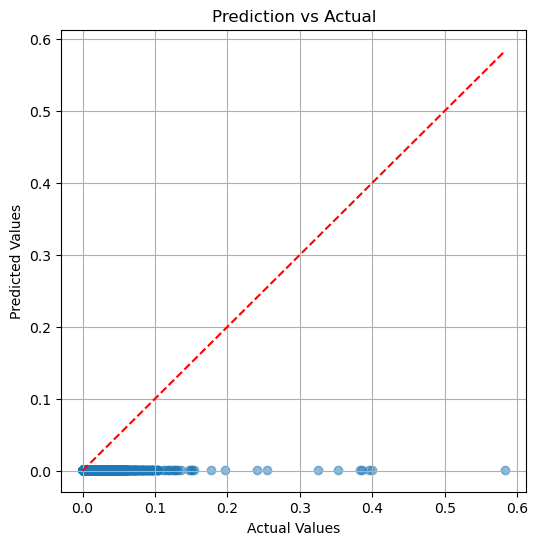

In [45]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line showing perfect predictions
plt.grid(True)
plt.show()


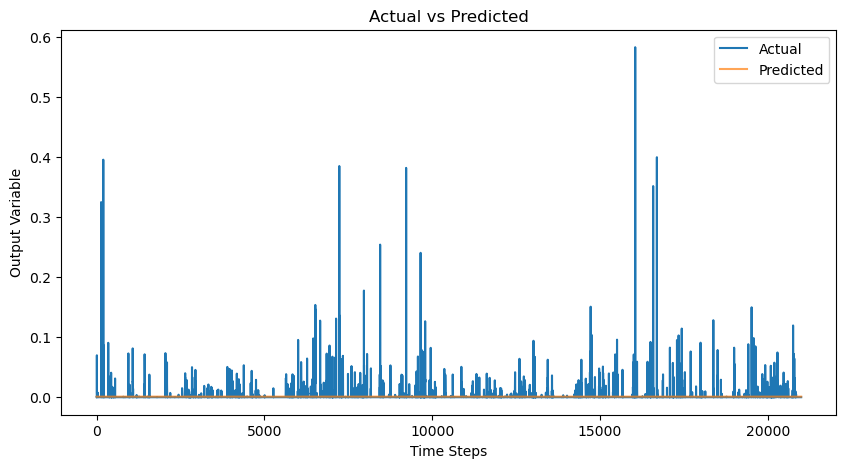

In [44]:
# Plotting results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Output Variable')
plt.legend()
plt.show()

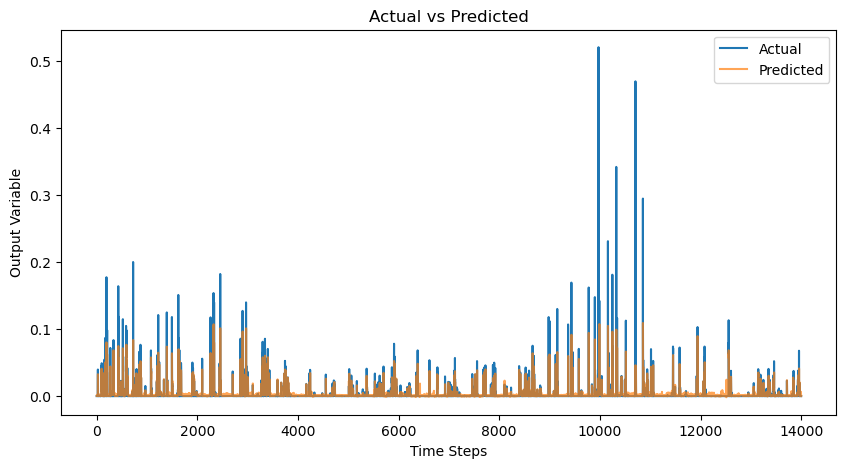

In [9]:
# Plotting results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Output Variable')
plt.legend()
plt.show()

In [11]:
# cross validation, another model

from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model

def cross_validate_model(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, test_index in kf.split(X):
        model_clone = clone_model(model)
        model_clone.compile(optimizer='adam', loss='mse')
        
        X_train_kf, X_test_kf = X[train_index], X[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]
        
        model_clone.fit(X_train_kf, y_train_kf, epochs=10, batch_size=32, verbose=1)
        y_pred_kf = model_clone.predict(X_test_kf)
        mse_kf = mean_squared_error(y_test_kf, y_pred_kf)
        mse_scores.append(mse_kf)
    
    return mse_scores

# Assuming X_train and y_train are already defined and preprocessed
mse_scores = cross_validate_model(X_train, y_train)
print("Cross-validated MSE Scores:", mse_scores)


Epoch 1/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 1.9168e-04
Epoch 2/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.4397e-04
Epoch 3/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.8645e-04
Epoch 4/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 2.6738e-04
Epoch 5/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 1.6444e-04
Epoch 6/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.4190e-04
Epoch 7/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.3544e-04
Epoch 8/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.2648e-04
Epoch 9/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.4053e-04
Epoch 10/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 1.3505e-04
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Epoch 1/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 1.6871e-04
Epoch 2/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 1.6501e-04
Epoch 3/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - 

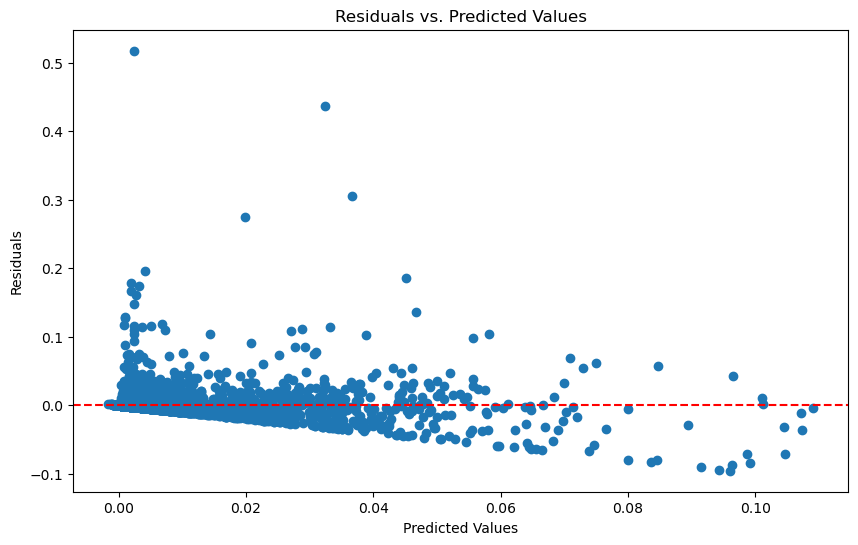

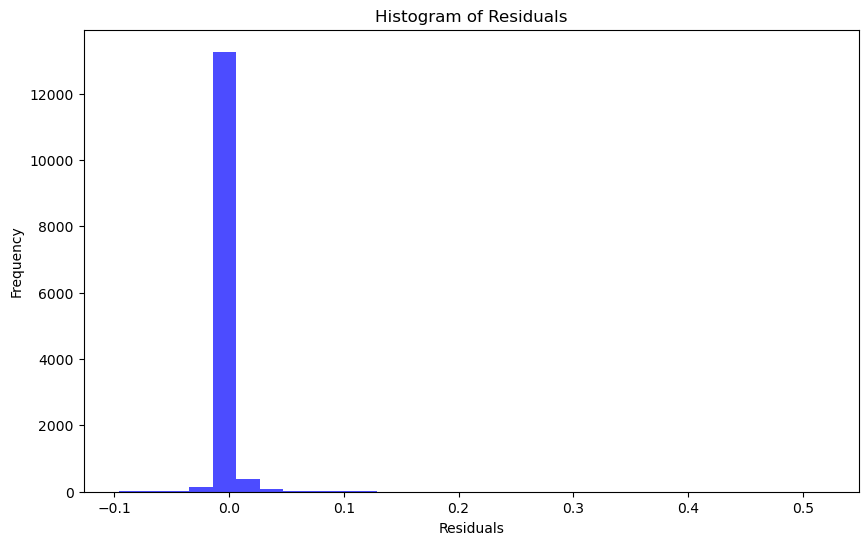

In [10]:
# Calculate residuals
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# Plotting histogram of residuals to check the distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
